**Reference**: <https://daviddalpiaz.github.io/appliedstats/transformations.html#response-transformation>

In [98]:
library(tidyverse)
library(broom)

# Why transformation?

Use transformations of both response and predictor variables in order to correct issues with model diagnostics, and to also potentially simply make a model fit data better.

# 1. Response Transformation

In [5]:
initech <- read_csv("https://raw.githubusercontent.com/daviddalpiaz/appliedstats/master/data/initech.csv")
head(initech)


-- Column specification ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
cols(
  years = col_double(),
  salary = col_double()
)




years,salary
<dbl>,<dbl>
1,41504
1,32619
1,44322
2,40038
2,46147
2,38447


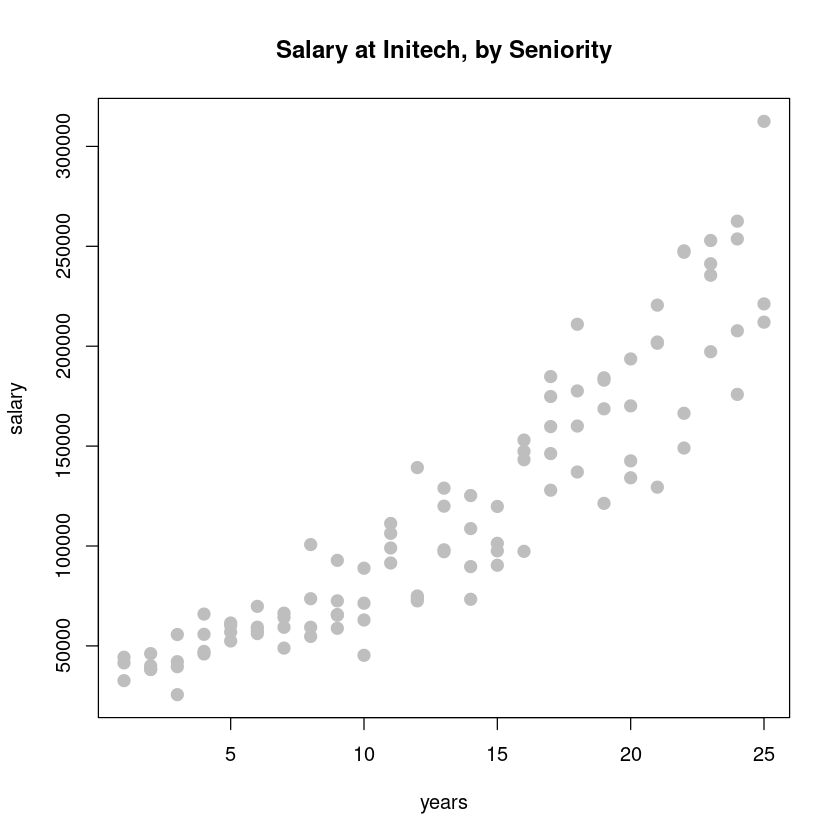

In [9]:
plot(salary ~ years, data = initech, main = "Salary at Initech, by Seniority", cex = 2, pch = 20, col = "grey")

In [12]:
initech_fit <- lm(salary ~ years, data = initech)

summary(initech_fit)


Call:
lm(formula = salary ~ years, data = initech)

Residuals:
   Min     1Q Median     3Q    Max 
-57225 -18104    241  15589  91332 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)     5302       5750   0.922    0.359    
years           8637        389  22.200   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 27360 on 98 degrees of freedom
Multiple R-squared:  0.8341,	Adjusted R-squared:  0.8324 
F-statistic: 492.8 on 1 and 98 DF,  p-value: < 2.2e-16


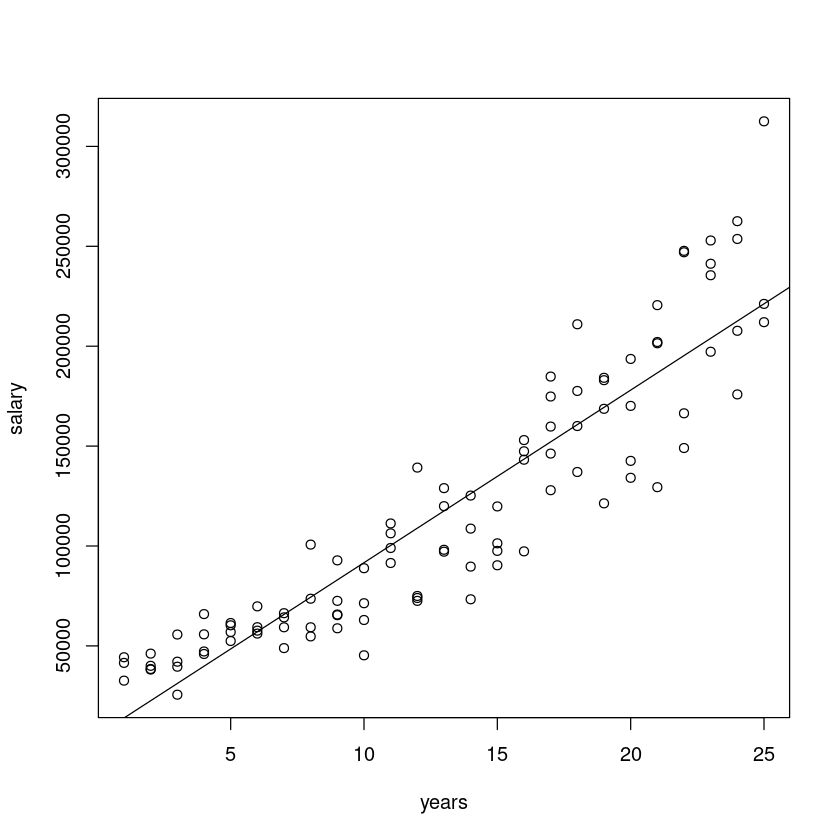

In [19]:
plot(salary ~ years, data = initech)
abline(coef(initech_fit))

This model appears significant, but does it meet our model assumptions?

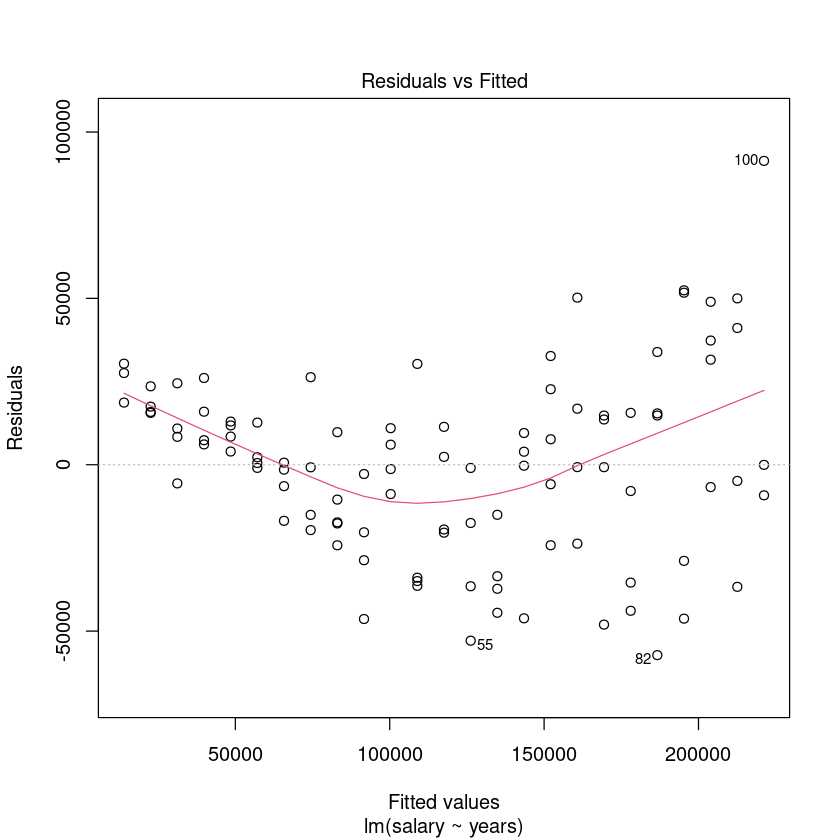

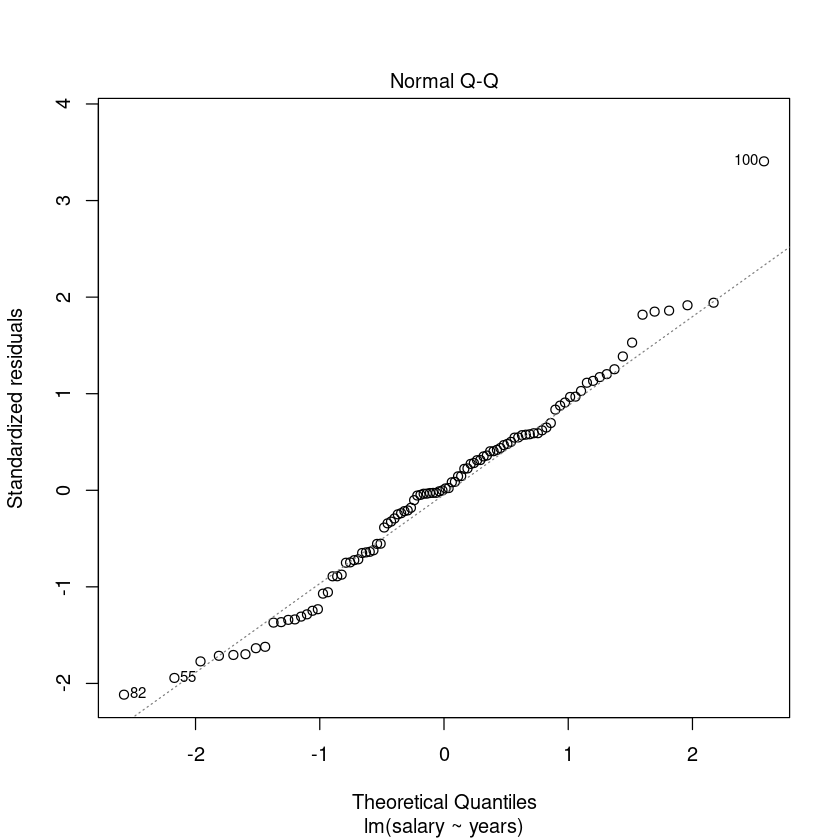

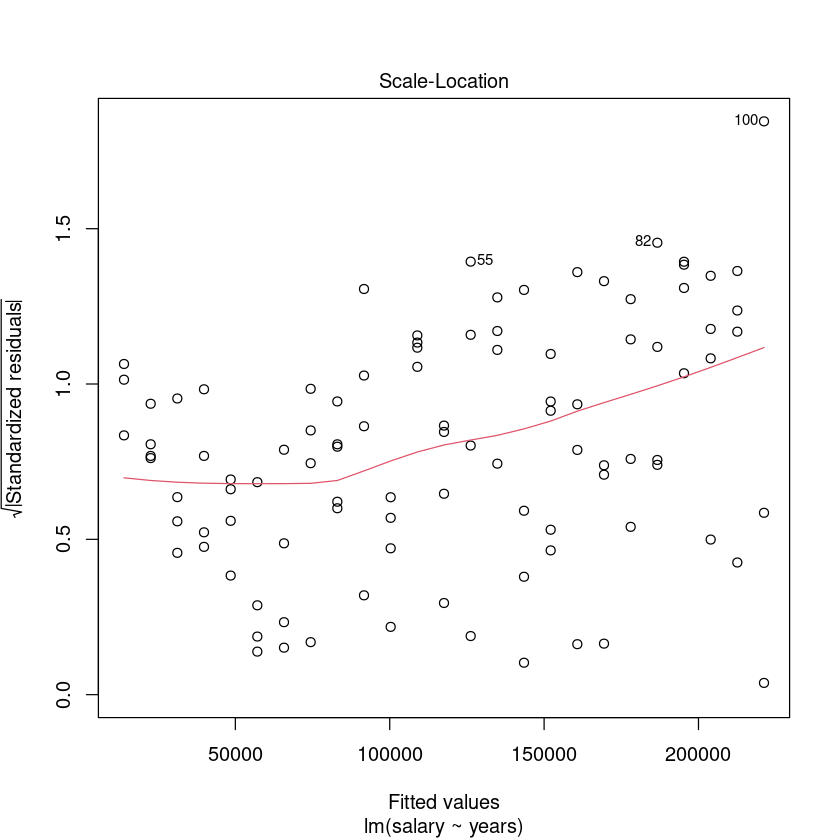

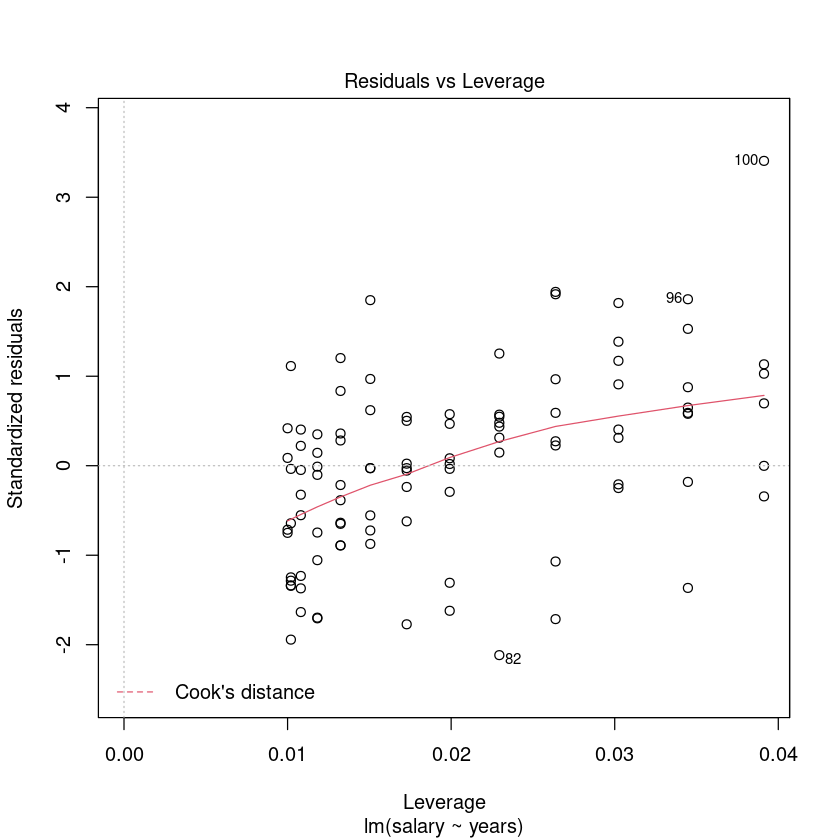

In [14]:
# model diagnostic
plot(initech_fit)

From the fitted versus residuals plot it appears there is non-constant variance. Specifically, the variance increases as the fitted value increases.

## 1.1 Variance stabilizing transformation

What is **variance stabilizing transformation**? Read the book

Basically, if is a function `g()` that satisfies: $Var[g(Y)|X = x] = c$  
where `c` is a constant that does not depend on the mean $E[Y|X = x]$


A common variance stabilizing transformation (VST) when we see increasing variance in a fitted versus residuals plot is log($Y$). Also, if the values of a variable range over more than one order of magnitude and the variable is strictly positive, then replacing the variable by its logarithm is likely to be helpful.

---
We will now use a model with a log transformed response for the Initech data,

$$log(Y_i) = \beta_0 + \beta_1 x_i + \epsilon_i$$  
Note, if we re-scale the model from a log scale back to the original scale of the data, we now have
$$Y_i = exp(\beta_0 + \beta_1 x_i)exp(\epsilon_i)$$  

In [20]:
initech_fit_log <- lm(log(salary) ~ years, data = initech)

summary(initech_fit_log)


Call:
lm(formula = log(salary) ~ years, data = initech)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57022 -0.13560  0.03048  0.14157  0.41366 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.48381    0.04108  255.18   <2e-16 ***
years        0.07888    0.00278   28.38   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1955 on 98 degrees of freedom
Multiple R-squared:  0.8915,	Adjusted R-squared:  0.8904 
F-statistic: 805.2 on 1 and 98 DF,  p-value: < 2.2e-16


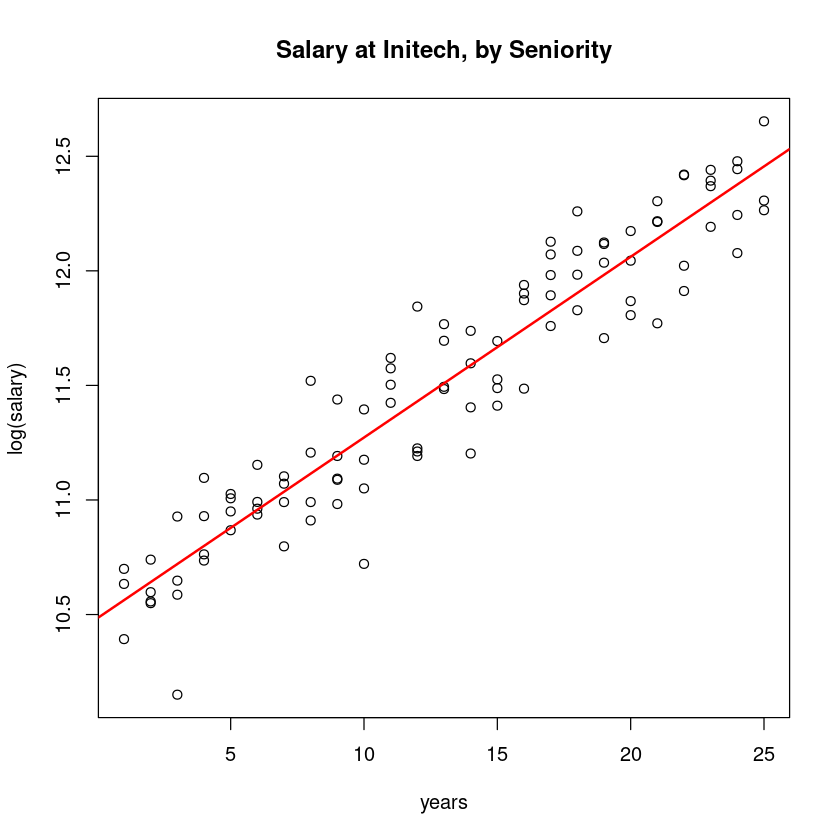

In [24]:
plot(log(salary) ~ years, data = initech, main = "Salary at Initech, by Seniority")
abline(coef(initech_fit_log), lwd = 2, col = "red")

Plotting the data on the transformed log scale and adding the fitted line, the relationship again appears linear, and we can already see that the variation about the fitted line looks constant.

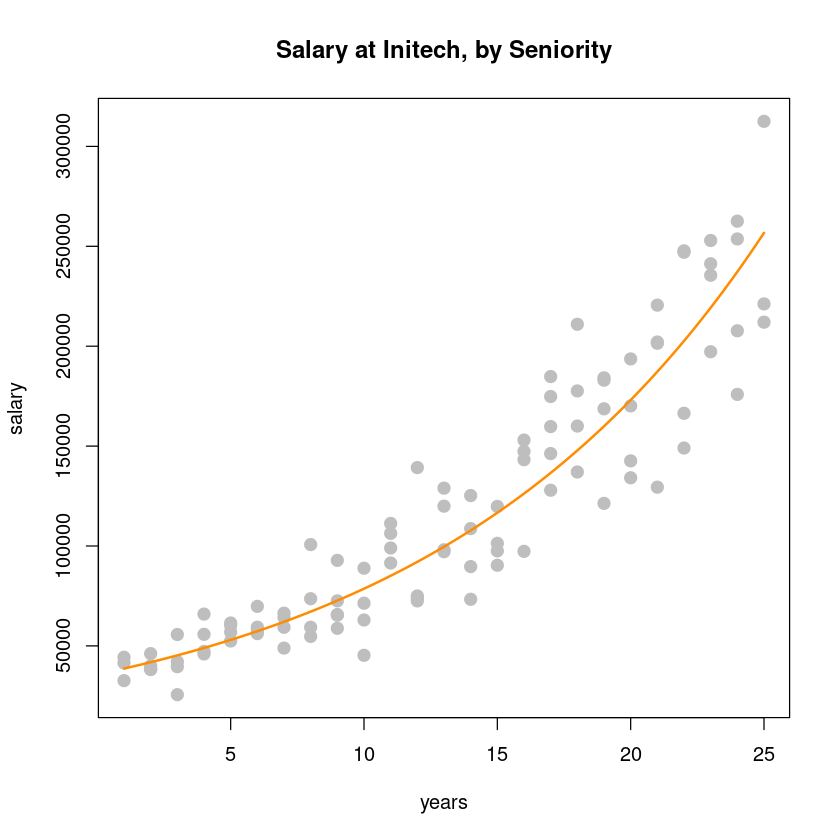

In [29]:
plot(salary ~ years, data = initech, pch = 20, col = "grey", cex = 2, main = "Salary at Initech, by Seniority")
curve(exp(coef(initech_fit_log)[[1]] + coef(initech_fit_log)[[2]] * x), add = T, col = "darkorange", lwd = 2)

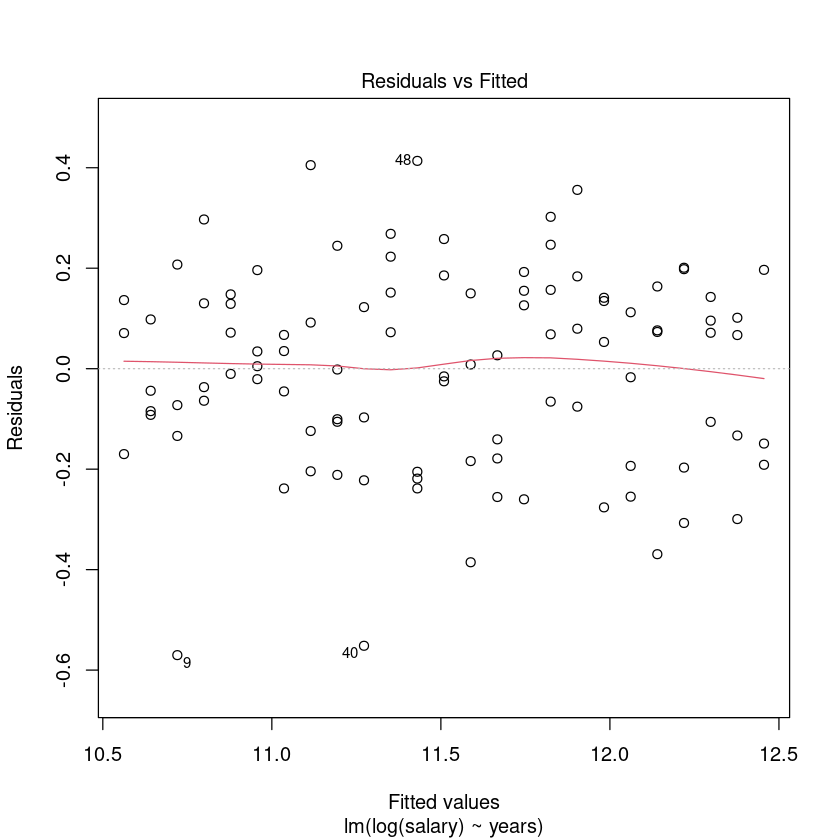

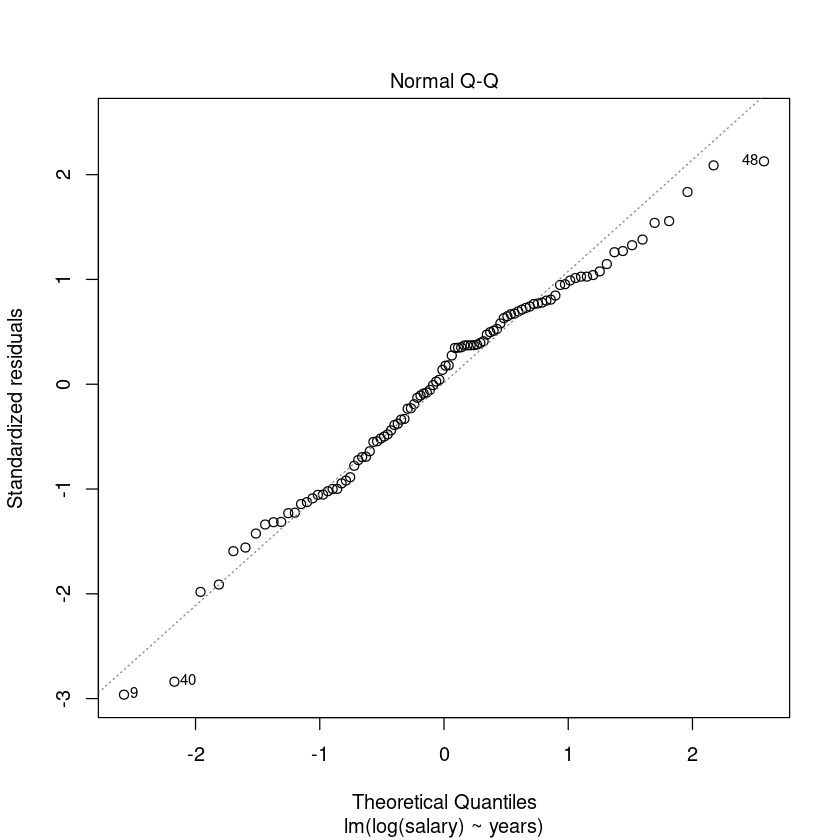

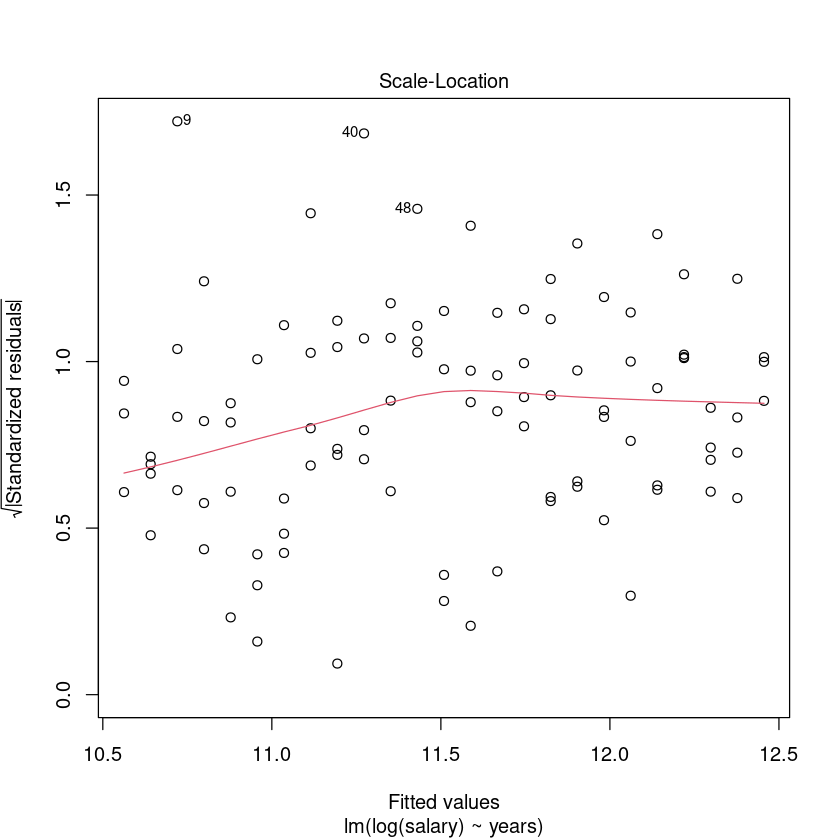

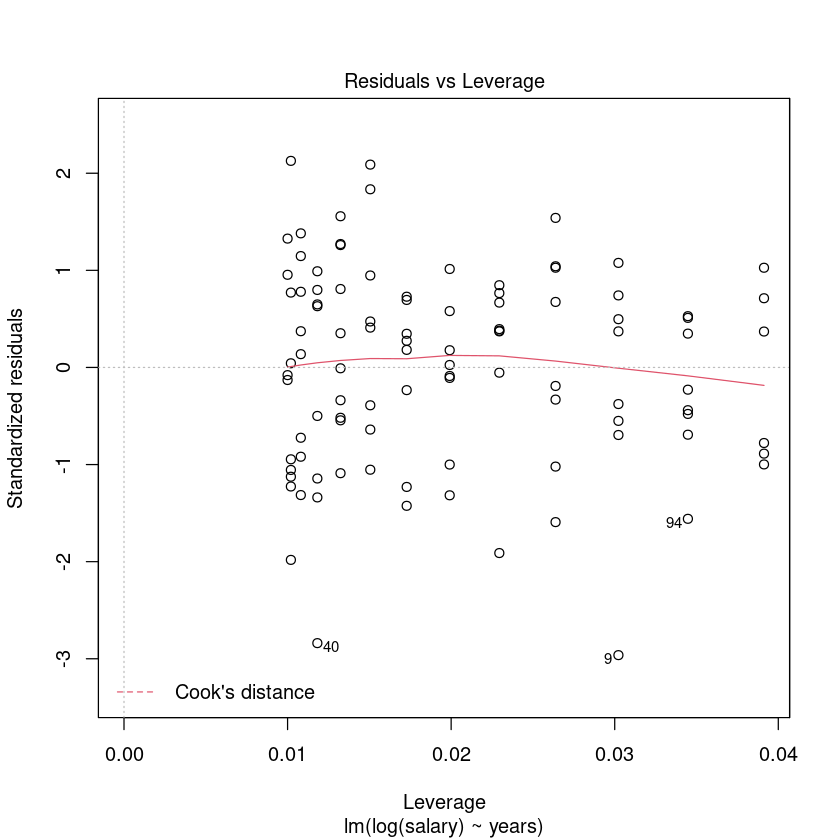

In [26]:
# model diagnostic
plot(initech_fit_log)

Now, look at the residuals versus fitted plot after transform `salary` to log scale, the variance appears to be constant now.

Comparing the RMSE using the original and transformed response, we also see that the log transformed model simply fits better, with a smaller average squared error.

In [30]:
sqrt(mean(resid(initech_fit)^2))

[1] 27080.16

In [32]:
sqrt(mean((exp(fitted(initech_fit_log)) - initech$salary)^2))

[1] 24280.36

Again, the transformed response is a linear combination of the predictors,



$$log(\hat{y}) = \beta_0 + \beta_1 x$$ or equivalent
$$\hat{y} = e^{\beta_0} e^{\beta_1 x}$$

In [34]:
coef(initech_fit_log)

(Intercept)       years 
10.48380621  0.07887976

We see that for every additional year of experience, average salary increase by $e^{\beta_1}$ times, approximately:

In [35]:
exp(coef(initech_fit_log)[[2]])

[1] 1.082074

**NOTES**: we are **multiplying**, not **adding**

While using a   log transform is possibly the most common response variable transformation, many others exist. We will now consider a family of transformations and choose the best from among them, which includes the   log transform.

## 1.2 Box-cox transform

**Read the book for the math**  
The Box-Cox method considers a family of transformations on strictly positive response variables. This function has a hyperparameter $\lambda$,  using R, we often choose a “nice” value from within the confidence interval, instead of the value of   λ that truly maximizes the likelihood.

$$g_\lambda(y) = \left\{
\begin{array}{lr}\displaystyle\frac{y^\lambda - 1}{\lambda} &  \lambda \neq 0\\
        & \\
       \log(y) &  \lambda = 0
     \end{array}
   \right.$$

Find $\lambda$ that maximizes that likelihood:  
$$L(\lambda) = -\frac{n}{2}\log(RSS_\lambda / n) + (\lambda -1)\sum \log(y_i).$$

A  $100 ( 1 − α )$% confidence interval for   λ is,

$$\left\{ \lambda :  L(\lambda) > L(\hat{\lambda}) - \frac{1}{2}\chi_{1,\alpha}^2  \right\}$$

> we will use **`MASS::boxcox()`** for box-cox transformation

In [37]:
library(MASS)
# we will use some datasets from the faraway package
library(faraway)

In [38]:
head(savings)

,sr,pop15,pop75,dpi,ddpi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Australia,11.43,29.35,2.87,2329.68,2.87
Austria,12.07,23.32,4.41,1507.99,3.93
Belgium,13.17,23.80,4.43,2108.47,3.82
Bolivia,5.75,41.89,1.67,189.13,0.22
Brazil,12.88,42.19,0.83,728.47,4.56
Canada,8.79,31.72,2.85,2982.88,2.43


In [39]:
savings_model <- lm(sr ~ ., data = savings)

We then use the `boxcox()` function to find the best transformation of the form considered by the Box-Cox method.

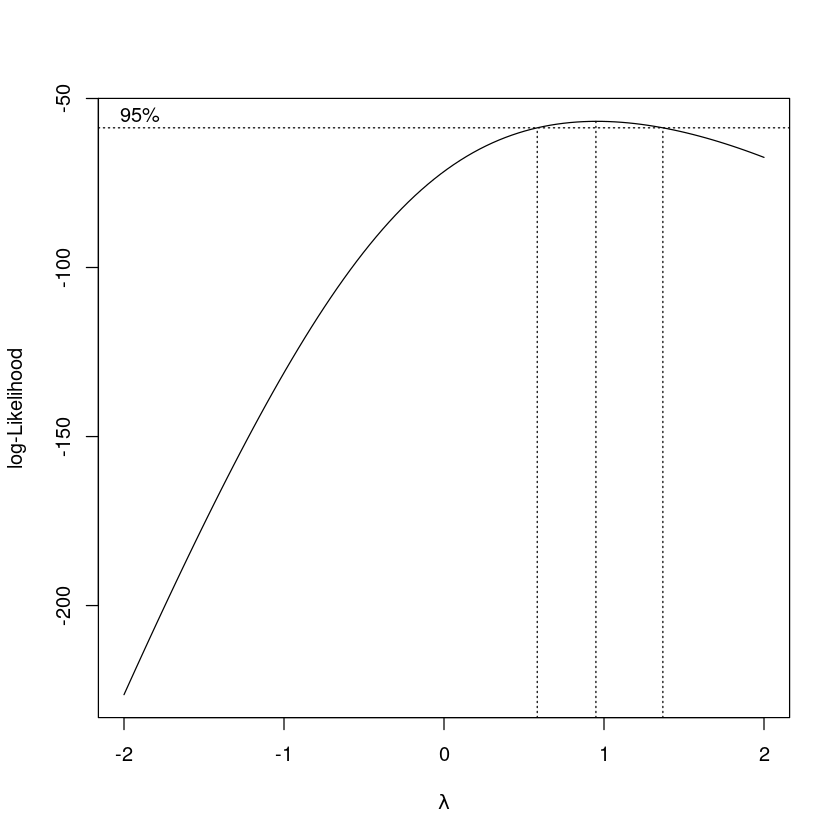

In [40]:
boxcox(savings_model)

R automatically plots the log-Likelihood as a function of possible   λ values. It indicates both the value that maximizes the log-likelihood, as well as a confidence interval for the   λ value that maximizes the log-likelihood.

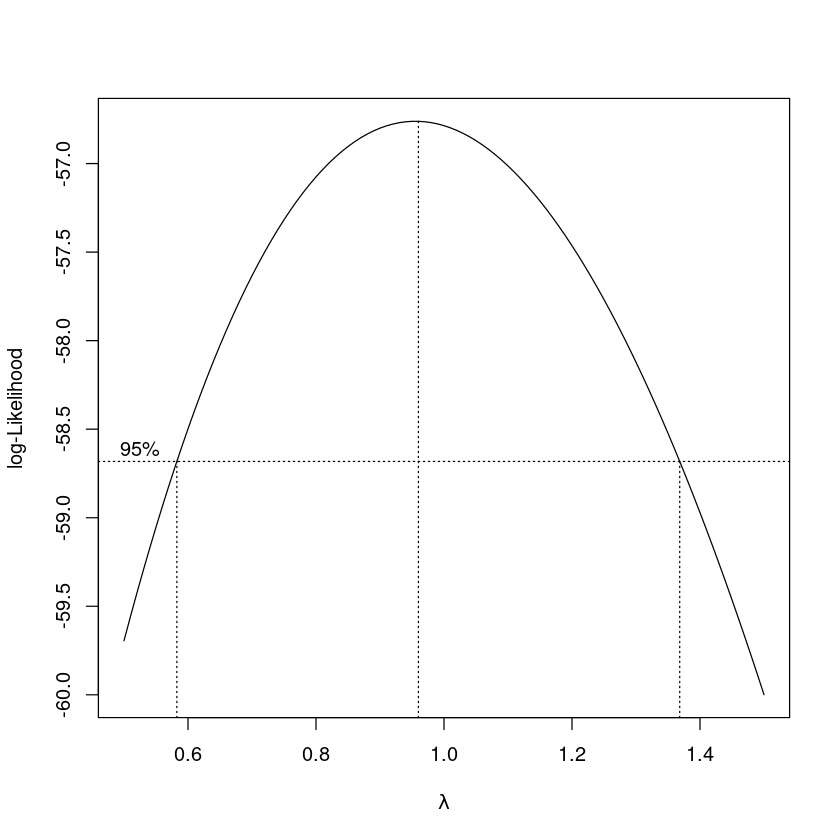

In [44]:
boxcox(savings_model, lambda = seq(0.5, 1.5, 0.01))

Note that we can specify a range of   λ values to consider and thus be plotted. We often specify a range that is more visually interesting. Here we see that   λ = 1 is both in the confidence interval, and is extremely close to the maximum. This suggests a transformation of the form

$$\frac{y^\lambda - 1}{\lambda} = \frac{y^1 - 1}{1} = y - 1.$$

This is essentially not a transformation. It would not change the variance or make the model fit better. By subtracting 1 from every value, we would only change the intercept of the model, and the resulting errors would be the same.

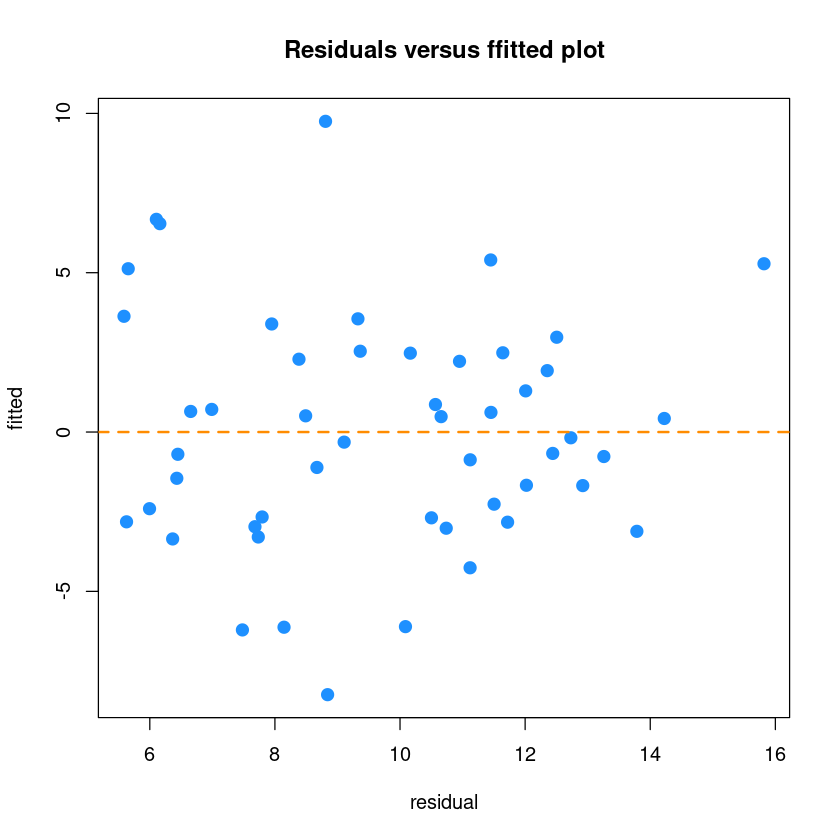

In [47]:
plot(fitted(savings_model), resid(savings_model), pch = 20, col = "dodgerblue", cex = 2, main = "Residuals versus ffitted plot", xlab = "residual", ylab = "fitted")
abline(h = 0, lwd = 2, lty = 2, col = "darkorange")

Looking at a fitted versus residuals plot verifies that there likely are not any issue with the assumptions of this model, which Breusch-Pagan and Shapiro-Wilk tests verify.

In [50]:
library(lmtest)

# test for constant variance, H_0: equal variance
bptest(savings_model)


	studentized Breusch-Pagan test

data:  savings_model
BP = 4.9852, df = 4, p-value = 0.2888


In [51]:
# test for normal, H_0: residuals are from normal distribution
shapiro.test(resid(savings_model))


	Shapiro-Wilk normality test

data:  resid(savings_model)
W = 0.98698, p-value = 0.8524


---
Now we will use the `gala` dataset as an example of using the Box-Cox method to justify a transformation other than   log . We fit an additive multiple regression model with `Species` as the response and most of the other variables as predictors.

In [52]:
head(gala)

,Species,Endemics,Area,Elevation,Nearest,Scruz,Adjacent
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Baltra,58,23,25.09,346,0.6,0.6,1.84
Bartolome,31,21,1.24,109,0.6,26.3,572.33
Caldwell,3,3,0.21,114,2.8,58.7,0.78
Champion,25,9,0.10,46,1.9,47.4,0.18
Coamano,2,1,0.05,77,1.9,1.9,903.82
Daphne.Major,18,11,0.34,119,8.0,8.0,1.84


In [55]:
# using every variables except Endemics
gala_model <- lm(Species ~ . - Endemics, data = gala)
summary(gala_model)


Call:
lm(formula = Species ~ . - Endemics, data = gala)

Residuals:
     Min       1Q   Median       3Q      Max 
-111.679  -34.898   -7.862   33.460  182.584 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.068221  19.154198   0.369 0.715351    
Area        -0.023938   0.022422  -1.068 0.296318    
Elevation    0.319465   0.053663   5.953 3.82e-06 ***
Nearest      0.009144   1.054136   0.009 0.993151    
Scruz       -0.240524   0.215402  -1.117 0.275208    
Adjacent    -0.074805   0.017700  -4.226 0.000297 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 60.98 on 24 degrees of freedom
Multiple R-squared:  0.7658,	Adjusted R-squared:  0.7171 
F-statistic:  15.7 on 5 and 24 DF,  p-value: 6.838e-07


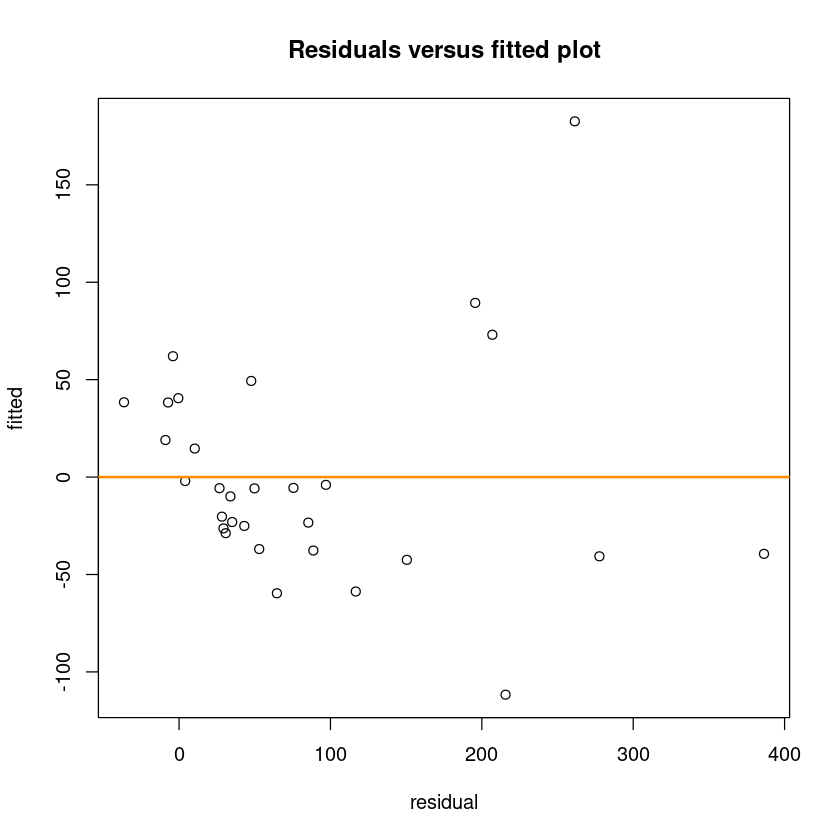

In [56]:
plot(fitted(gala_model), resid(gala_model), main = "Residuals versus fitted plot", xlab = "residual", ylab = "fitted")
abline(h = 0, lwd = 2, col = "darkorange")

Even though there is not a lot of data for large fitted values, it still seems very clear that the constant variance assumption is violated.

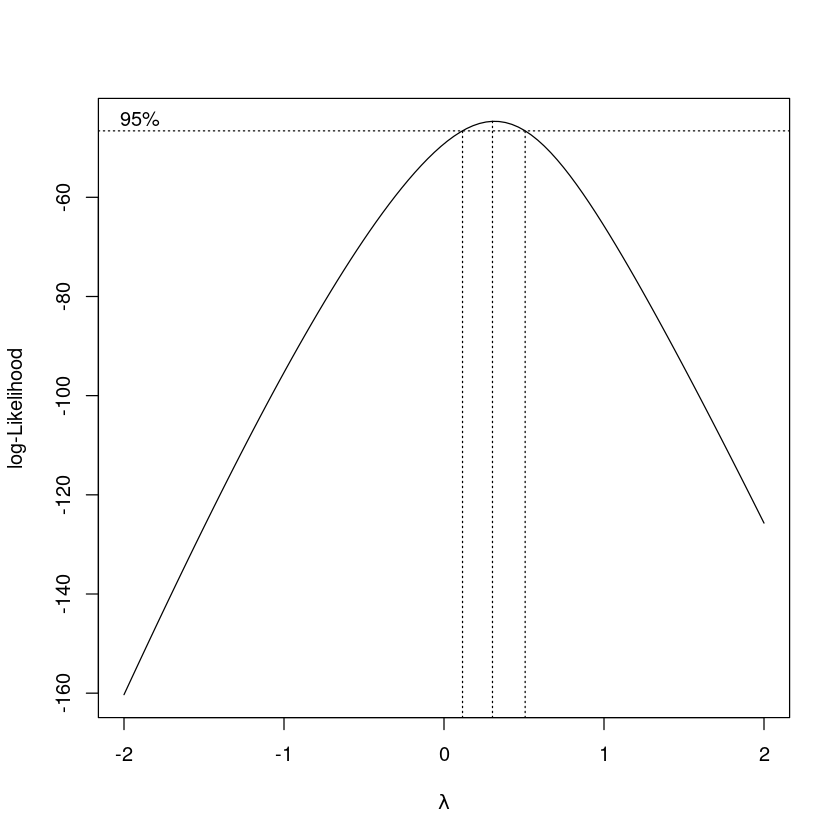

In [57]:
boxcox(gala_model)

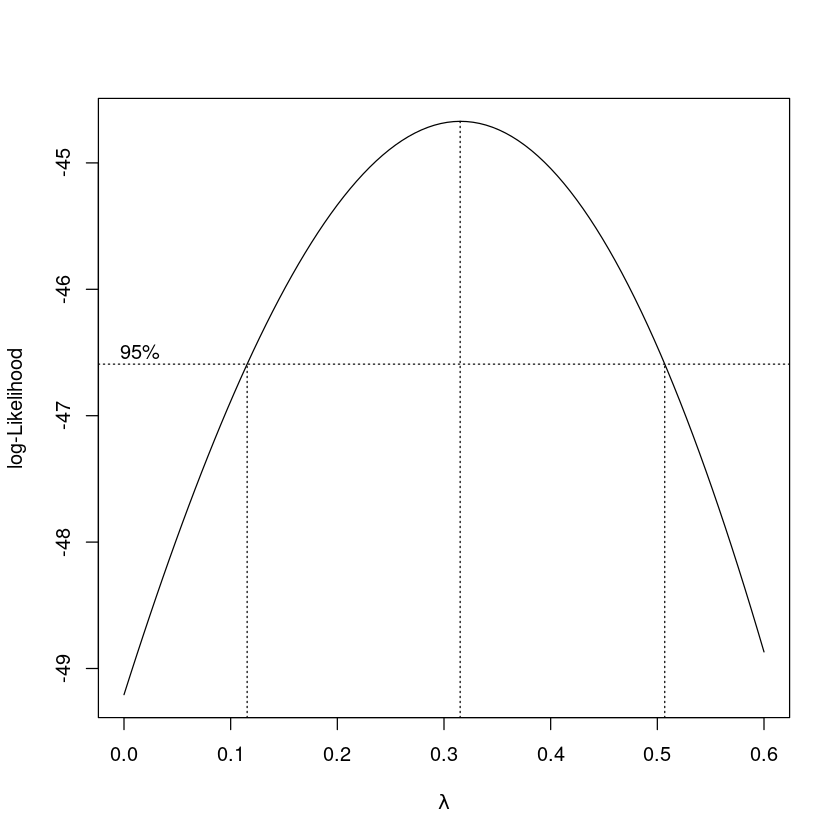

In [58]:
boxcox(gala_model, lambda = seq(0, .6, 0.05))

Chose $\lambda$ = 0.3,  both in the confidence interval, and is extremely close to the maximum, which suggests a transformation of the form
$$\frac{y^\lambda - 1}{\lambda} = \frac{y^{0.3} - 1}{0.3}$$



We then fit a model with this transformation applied to the response.

In [61]:
gala_model_cox <- lm((Species^.3 - 1) / .3 ~ . - Endemics, data = gala)

summary(gala_model_cox)


Call:
lm(formula = (Species^0.3 - 1)/0.3 ~ . - Endemics, data = gala)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1301 -1.4007 -0.2357  1.5423  4.9260 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.5618689  0.8144515   4.373 0.000204 ***
Area        -0.0019671  0.0009534  -2.063 0.050074 .  
Elevation    0.0142730  0.0022818   6.255 1.83e-06 ***
Nearest      0.0329434  0.0448227   0.735 0.469478    
Scruz       -0.0120948  0.0091591  -1.321 0.199114    
Adjacent    -0.0027477  0.0007526  -3.651 0.001267 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.593 on 24 degrees of freedom
Multiple R-squared:  0.7457,	Adjusted R-squared:  0.6927 
F-statistic: 14.07 on 5 and 24 DF,  p-value: 1.779e-06


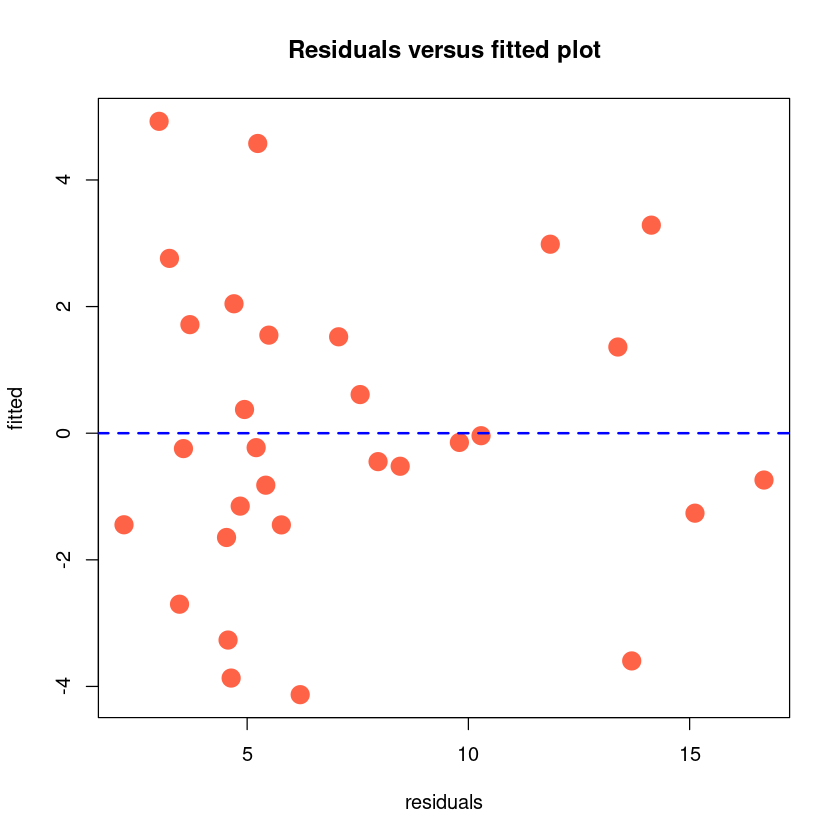

In [66]:
plot(fitted(gala_model_cox), resid(gala_model_cox), pch = 20, cex = 3, col = "tomato", main = "Residuals versus fitted plot", xlab = "residuals", ylab = "fitted")
abline(h = 0, lwd = 2, lty = 2, col = "blue")

The resulting fitted versus residuals plot looks much better!

Lastly, we return to the `initech` data, and the `initech_fit` model we had used earlier. Recall, that this was the untransformed model, that we used a   log transform to fix.

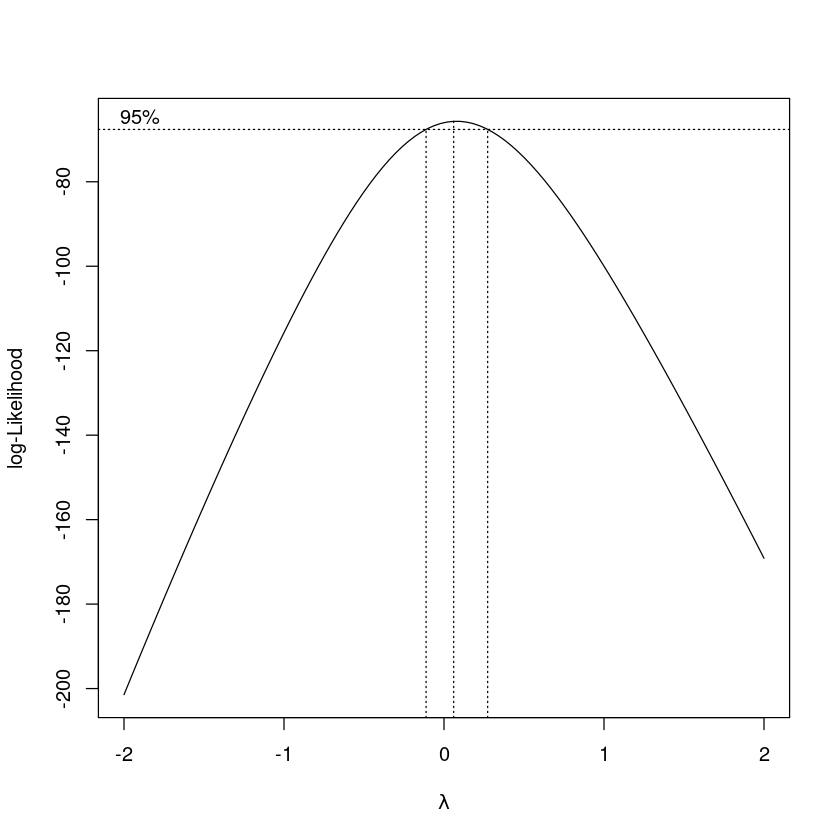

In [67]:
boxcox(initech_fit)

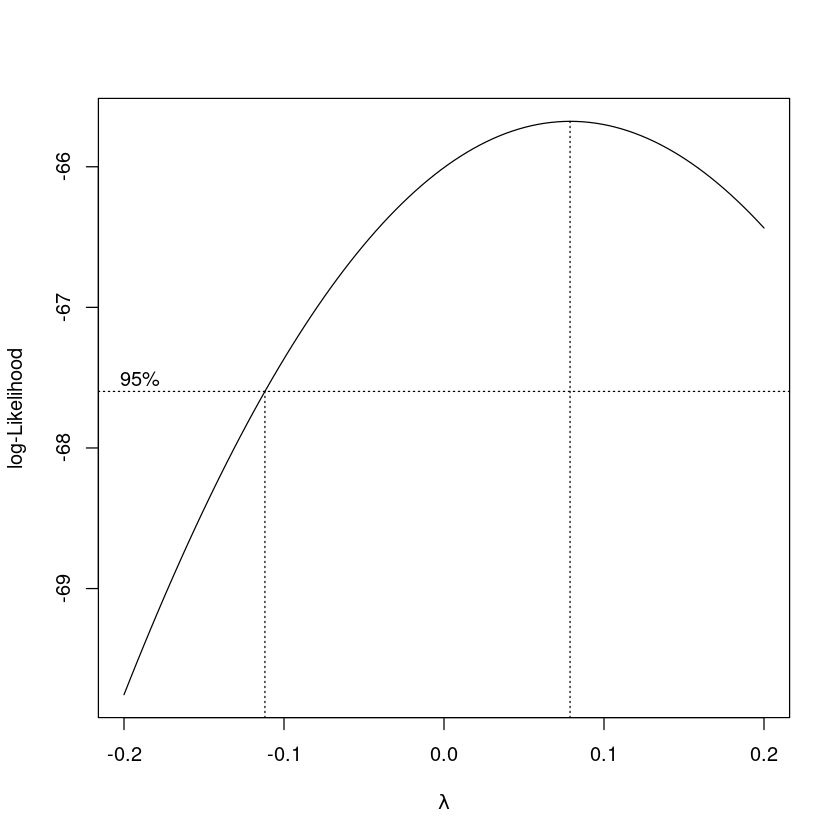

In [71]:
boxcox(initech_fit, lambda = seq(-0.2, 0.2, 0.01))

Chose $\lambda$ = 0.1

In [72]:
initech_fit_cox <- lm((salary^0.1 - 1) / 0.1 ~ years, data = initech)

summary(initech_fit_cox)


Call:
lm(formula = (salary^0.1 - 1)/0.1 ~ years, data = initech)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.70245 -0.40276  0.06068  0.43552  1.27103 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 18.42407    0.12948  142.30   <2e-16 ***
years        0.24935    0.00876   28.46   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.616 on 98 degrees of freedom
Multiple R-squared:  0.8921,	Adjusted R-squared:  0.891 
F-statistic: 810.2 on 1 and 98 DF,  p-value: < 2.2e-16


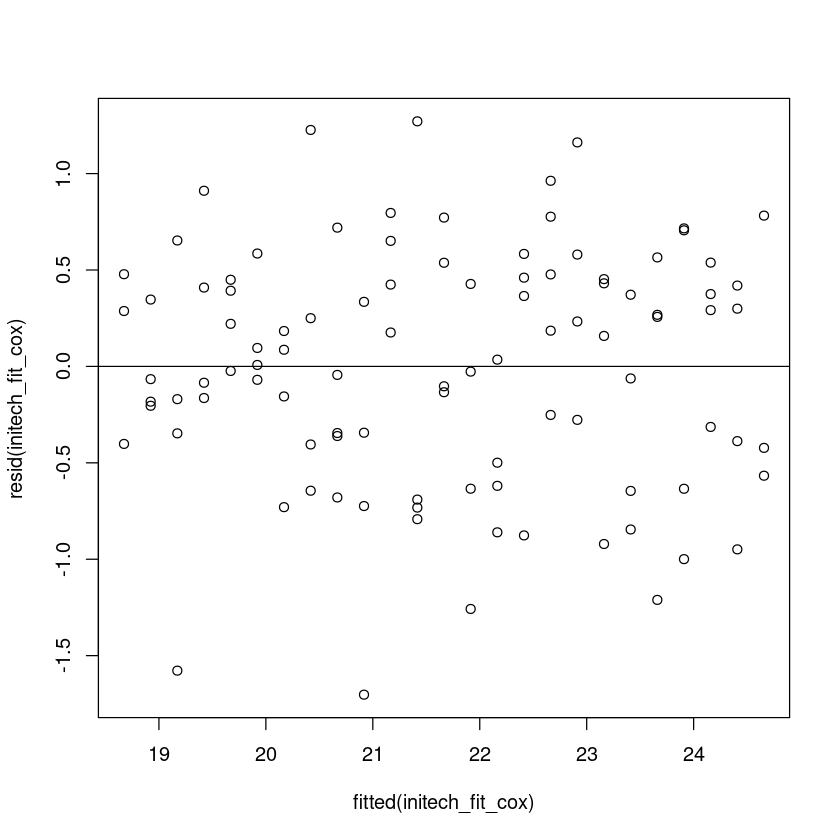

In [73]:
plot(fitted(initech_fit_cox), resid(initech_fit_cox))
abline(h = 0)

# 2. Predictor Transformation

**why?**: In addition to transformation of the response variable, we can also consider transformations of predictor variables. Sometimes these transformations can help with violation of model assumptions, and other times they can be used to simply fit a more flexible model.



In [74]:
autompg = read.table(
  "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data",
  quote = "\"",
  comment.char = "",
  stringsAsFactors = FALSE)
# give the dataframe headers
colnames(autompg) = c("mpg", "cyl", "disp", "hp", "wt", "acc", "year", "origin", "name")
# remove missing data, which is stored as "?"
autompg = subset(autompg, autompg$hp != "?")
# remove the plymouth reliant, as it causes some issues
autompg = subset(autompg, autompg$name != "plymouth reliant")
# give the dataset row names, based on the engine, year and name
rownames(autompg) = paste(autompg$cyl, "cylinder", autompg$year, autompg$name)
# remove the variable for name, as well as origin
autompg = subset(autompg, select = c("mpg", "cyl", "disp", "hp", "wt", "acc", "year"))
# change horsepower from character to numeric
autompg$hp = as.numeric(autompg$hp)
# check final structure of data
str(autompg)

'data.frame':	390 obs. of  7 variables:
 $ mpg : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cyl : int  8 8 8 8 8 8 8 8 8 8 ...
 $ disp: num  307 350 318 304 302 429 454 440 455 390 ...
 $ hp  : num  130 165 150 150 140 198 220 215 225 190 ...
 $ wt  : num  3504 3693 3436 3433 3449 ...
 $ acc : num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ year: int  70 70 70 70 70 70 70 70 70 70 ...


Here, we will try to model `mpg` as a function of `hp`

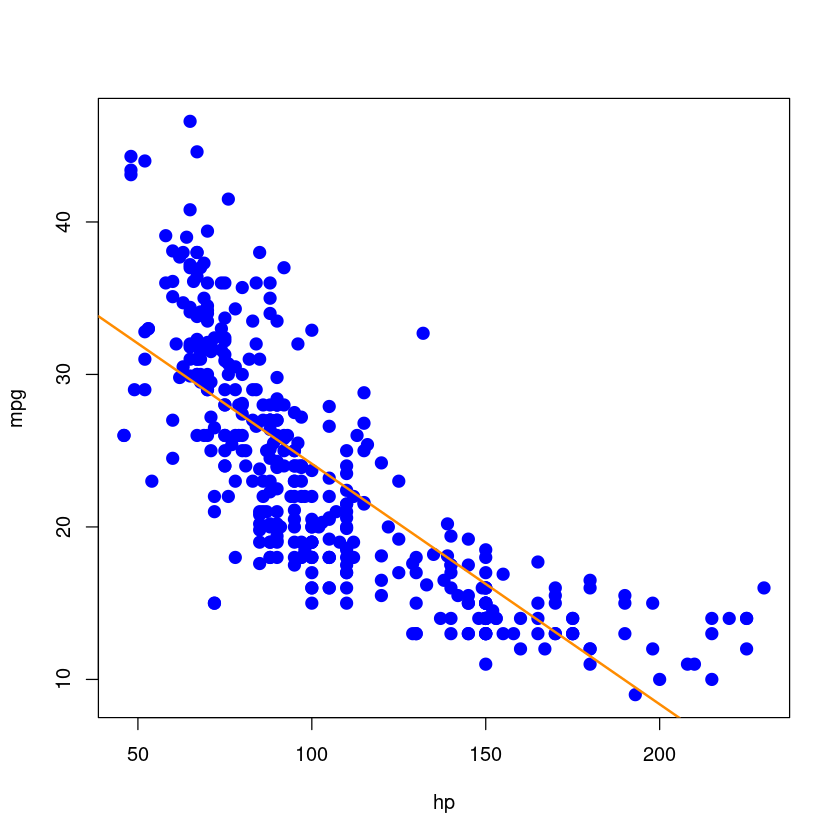

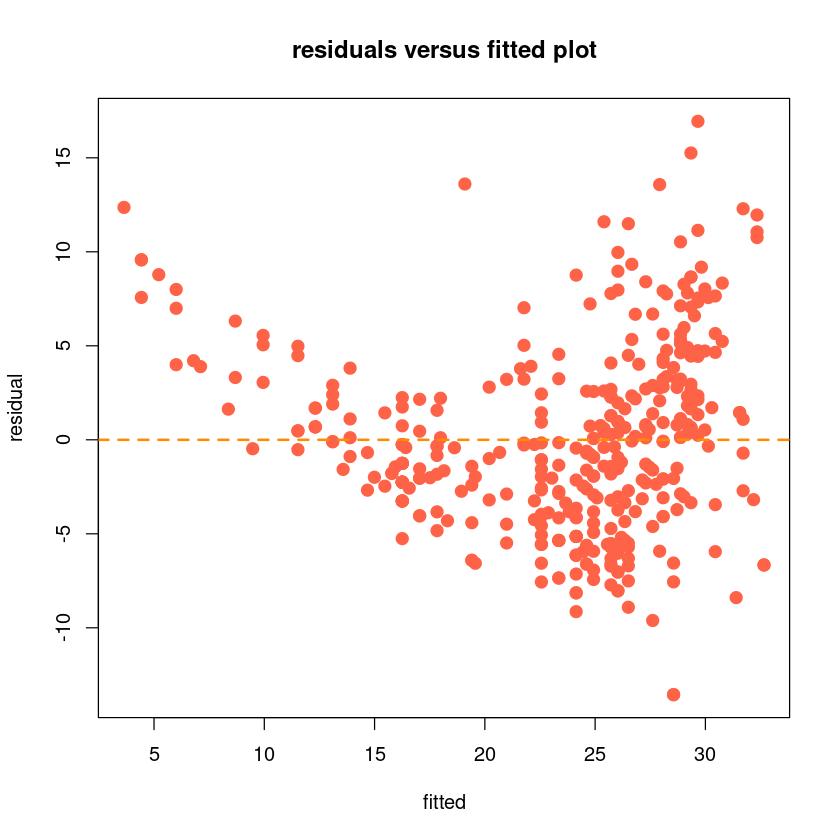

In [87]:
mpg_hp <- lm(mpg ~ hp, data = autompg)
plot(mpg ~ hp, data = autompg, pch = 20, col = "blue", cex = 2)
abline(coef(mpg_hp), lwd = 2, col = "darkorange")

plot(fitted(mpg_hp), resid(mpg_hp), pch = 20, col = "tomato", cex = 2, main = "residuals versus fitted plot", ylab = "residual", xlab = "fitted")
abline(h = 0, col = "darkorange", lwd = 2, lty = "dashed")

We first attempt SLR, but we see a rather obvious pattern in the fitted versus residuals plot, which includes increasing variance, so we attempt a   log transform of the response.



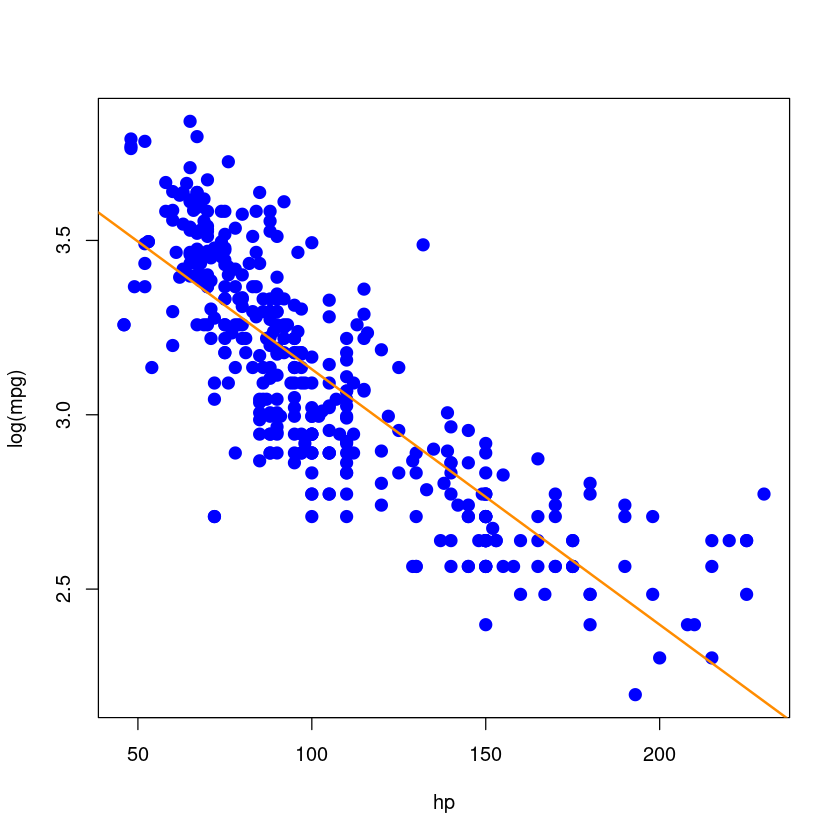

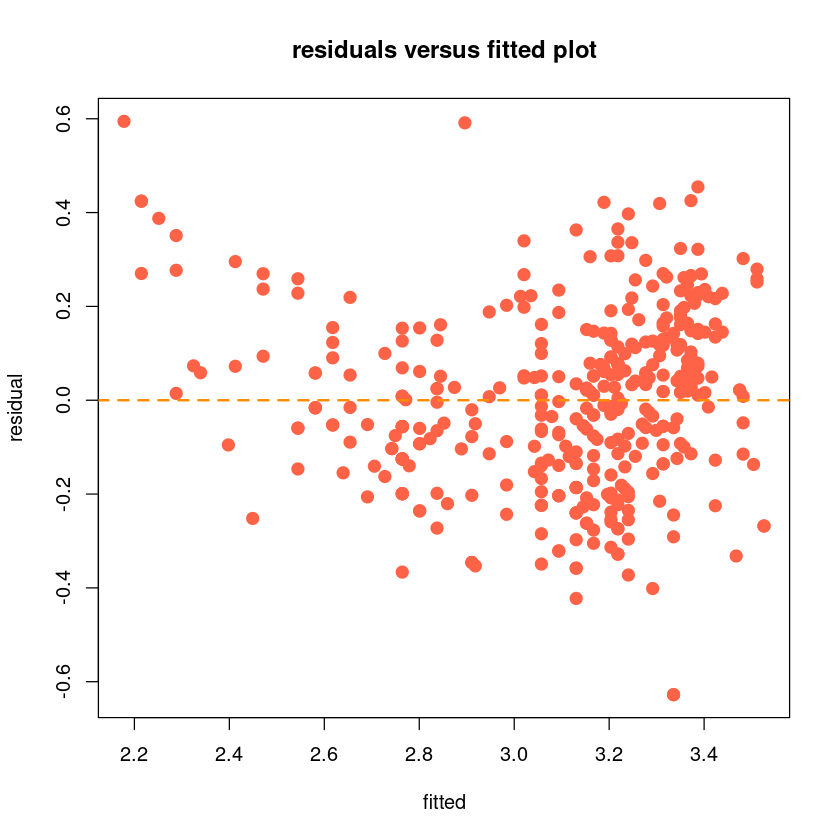

In [89]:
mpg_hp_log <- lm(log(mpg) ~ hp, data = autompg)
plot(log(mpg) ~ hp, data = autompg, pch = 20, col = "blue", cex = 2)
abline(coef(mpg_hp_log), lwd = 2, col = "darkorange")

plot(fitted(mpg_hp_log), resid(mpg_hp_log), pch = 20, col = "tomato", cex = 2, main = "residuals versus fitted plot", ylab = "residual", xlab = "fitted")
abline(h = 0, col = "darkorange", lwd = 2, lty = "dashed")

After performing the   log transform of the response, we still have some of the same issues with the fitted versus response. Now, we attempt to log transform both predictor `hp` and response `mpg`

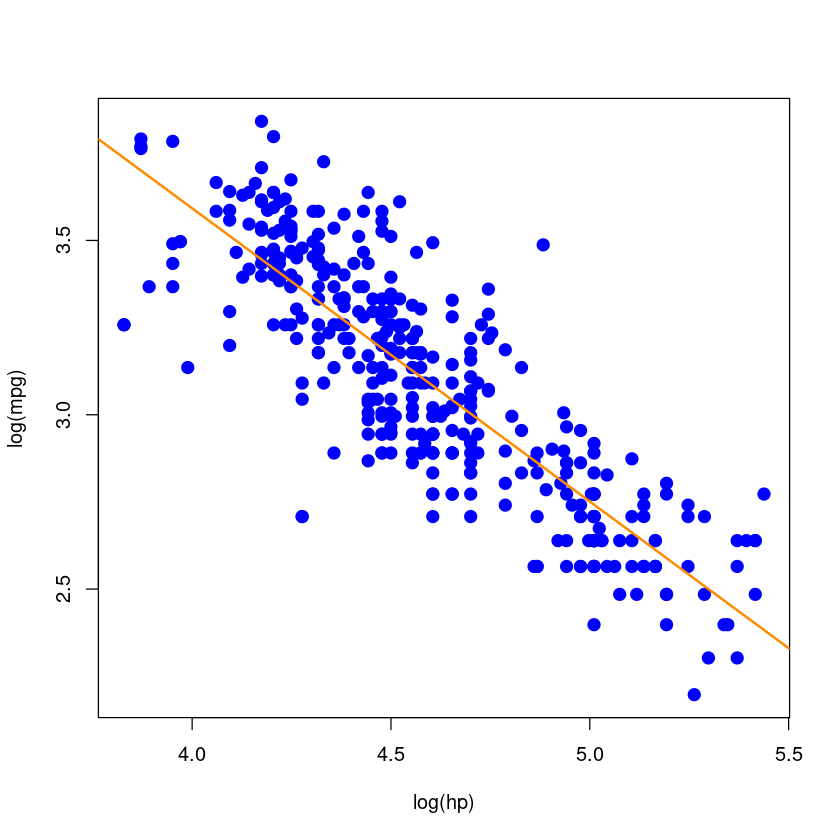

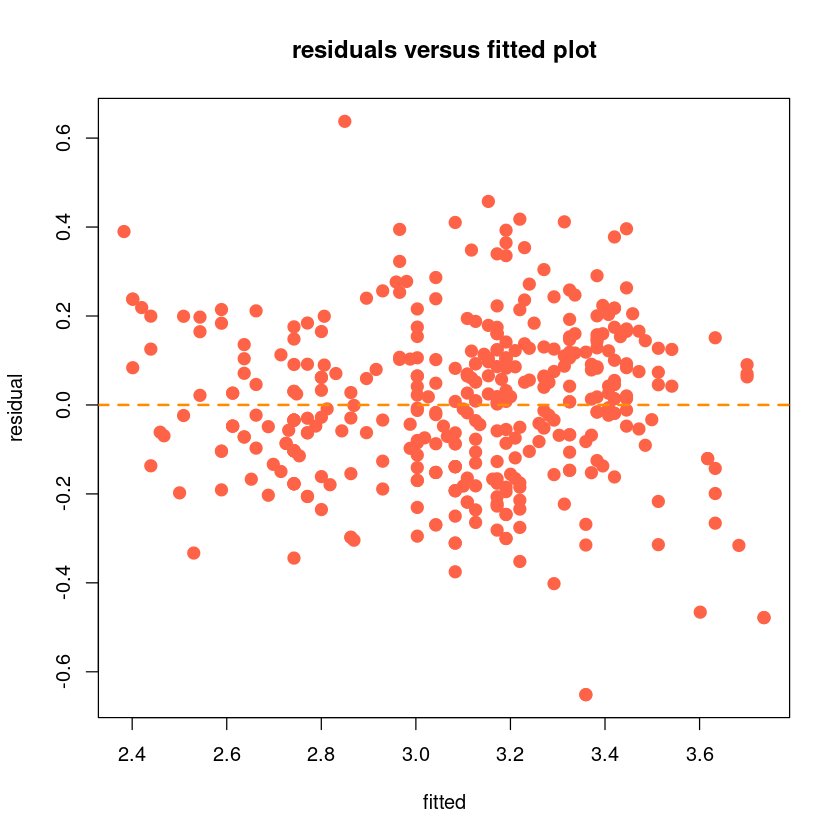

In [90]:
mpg_hp_log_log <- lm(log(mpg) ~ log(hp), data = autompg)
plot(log(mpg) ~ log(hp), data = autompg, pch = 20, col = "blue", cex = 2)
abline(coef(mpg_hp_log_log), lwd = 2, col = "darkorange")

plot(fitted(mpg_hp_log_log), resid(mpg_hp_log_log), pch = 20, col = "tomato", cex = 2, main = "residuals versus fitted plot", ylab = "residual", xlab = "fitted")
abline(h = 0, col = "darkorange", lwd = 2, lty = "dashed")

Here, our fitted vs residuals looks good!

## 2.1 Polynomials

It should come as no surprise that sales of a product are related to the advertising budget for the product, but there are diminishing returns. A company cannot always expect linear returns based on an increased advertising budget.

In [91]:
marketing <- read_csv("https://raw.githubusercontent.com/daviddalpiaz/appliedstats/master/data/marketing.csv")

marketing %>% glimpse()


-- Column specification ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
cols(
  sales = col_double(),
  advert = col_double()
)




Rows: 21
Columns: 2
$ sales  <dbl> 7.5, 8.5, 9.0, 9.5, 10.0, 10.5, 12.5, 13.3, 14.5, 15.5, 18.0...
$ advert <dbl> 0.7, 1.5, 1.3, 1.4, 1.7, 1.7, 2.0, 2.5, 3.2, 3.0, 4.5, 4.7, ...


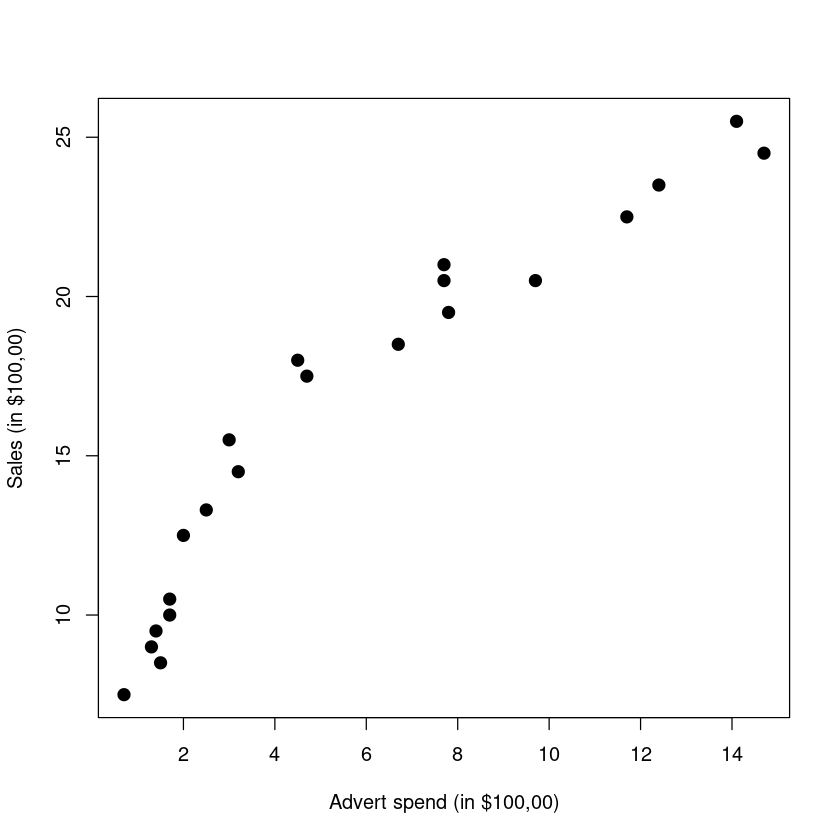

In [96]:
plot(sales ~ advert, data = marketing, pch = 20, cex = 2,
    xlab = "Advert spend (in $100,00)", ylab = "Sales (in $100,00)")

> using **`I()`** function to write transformation for predictors in the formula for linear regression

We will use second order polynomial

In [100]:
mark_mod_poly2 <- lm(sales ~ advert + I(advert ^ 2), data = marketing)

summary(mark_mod_poly2)


Call:
lm(formula = sales ~ advert + I(advert^2), data = marketing)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9175 -0.8333 -0.1948  0.9292  2.1385 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.76161    0.67219  10.059 8.16e-09 ***
advert       2.46231    0.24830   9.917 1.02e-08 ***
I(advert^2) -0.08745    0.01658  -5.275 5.14e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.228 on 18 degrees of freedom
Multiple R-squared:  0.9587,	Adjusted R-squared:  0.9541 
F-statistic:   209 on 2 and 18 DF,  p-value: 3.486e-13


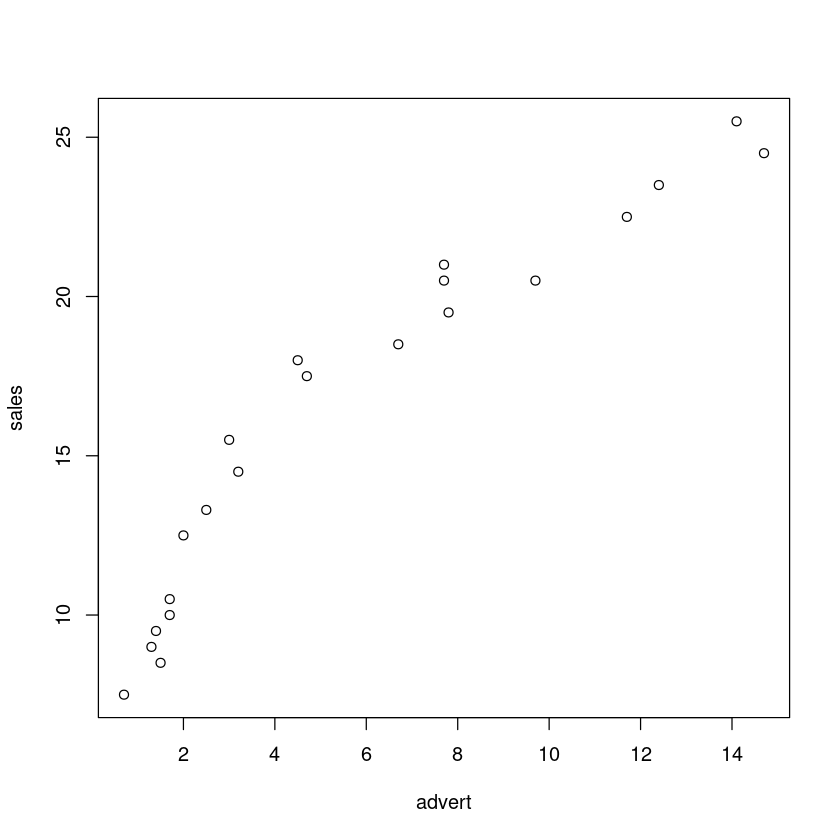

In [105]:
plot(sales ~ advert, data = marketing)
curve()

> using **`poly()`** function to transform predictor to polynomial

We can try higher order, let's say, 3 order

In [101]:
mark_mod_poly3 <- lm(sales ~ poly(advert, 3), data = marketing)
summary(mark_mod_poly3)


Call:
lm(formula = sales ~ poly(advert, 3), data = marketing)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.44322 -0.61310 -0.01527  0.68131  1.22517 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       16.3000     0.1818  89.681  < 2e-16 ***
poly(advert, 3)1  24.2549     0.8329  29.121 6.00e-16 ***
poly(advert, 3)2  -6.4776     0.8329  -7.777 5.35e-07 ***
poly(advert, 3)3   3.9177     0.8329   4.704 0.000205 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8329 on 17 degrees of freedom
Multiple R-squared:  0.9821,	Adjusted R-squared:  0.9789 
F-statistic: 310.2 on 3 and 17 DF,  p-value: 4.892e-15


or even a polynomial with 10 order

In [102]:
mark_mod_poly10 <- lm(sales ~ poly(advert, 10), data = marketing)
summary(mark_mod_poly10)


Call:
lm(formula = sales ~ poly(advert, 10), data = marketing)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.02568 -0.24127  0.01757  0.35456  0.94247 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        16.30000    0.16873  96.604 3.46e-16 ***
poly(advert, 10)1  24.25486    0.77322  31.369 2.55e-11 ***
poly(advert, 10)2  -6.47763    0.77322  -8.378 7.84e-06 ***
poly(advert, 10)3   3.91772    0.77322   5.067 0.000487 ***
poly(advert, 10)4  -1.31966    0.77322  -1.707 0.118683    
poly(advert, 10)5  -1.37019    0.77322  -1.772 0.106794    
poly(advert, 10)6  -0.07114    0.77322  -0.092 0.928513    
poly(advert, 10)7  -1.28543    0.77322  -1.662 0.127402    
poly(advert, 10)8   0.70316    0.77322   0.909 0.384536    
poly(advert, 10)9   0.20869    0.77322   0.270 0.792723    
poly(advert, 10)10  0.02413    0.77322   0.031 0.975719    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.77

In [104]:
modelr::gather_predictions(mark_mod_poly2, mark_mod_poly3, mark_mod_poly10)

ERROR: Error in as.data.frame.default(data): cannot coerce class '"lm"' to a data.frame
